In [1]:
import numpy as np
from scipy.special import erfcinv

class EdgeComputingEnvironment:
    def __init__(self, M=5, area_size=100, D_m=1354, eta_m_range=(100, 300), F_max_ue=1.5e9, P_max=23, B=5e6, T_max=10e-3, F_max_es=30e9, S_max_es=60e3, epsilon=10**-7, E_max=3e-3, theta=10**-26, L=8, phi=1.0, N0_dbm=-174, simulation_max_time=100):
        """
        Initialize the edge computing environment with given parameters.
        """
        self.M = M  # Number of users
        self.area_size = area_size  # Size of the area in which users are distributed
        self.D_m = D_m  # Task data size
        self.eta_m_range = eta_m_range  # Range of computation requirements
        self.F_max_ue = F_max_ue  # Maximum frequency of user equipment
        self.P_max = 10 ** (P_max / 10)  # Convert maximum transmission power from dB to Watts
        self.B = B  # Bandwidth
        self.T_max = T_max  # Maximum tolerable delay
        self.F_max_es = F_max_es  # Maximum frequency of edge server
        self.S_max_es = S_max_es  # Maximum storage size of edge server
        self.epsilon = epsilon  # Error tolerance for rate calculation
        self.E_max = E_max  # Maximum energy consumption
        self.theta = theta  # Energy coefficient
        self.L = L  # Number of antennas
        self.phi = phi  # Transmission probability
        self.R_min = 1e6  # Minimum data rate
        self.N0_dbm = N0_dbm  # Noise power in dBm
        self.N0 = 10 ** (N0_dbm / 10) / 1000  # Convert noise power from dBm/Hz to Watts/Hz
        self.simulation_max_time = simulation_max_time  # Maximum simulation time
        self.PL_d = lambda d: 10 ** ((-35.3 - 37.6 * np.log10(d)) / 10)  # Path loss model


        self.user_device_params = []  # List to store parameters for each user device
        self.initialize_user_device_params()  # Initialize user device parameters

        self.server_params = self.initialize_server_params()  # Initialize server parameters

        self.cache = []  # Cache to store tasks
        self.current_cache_size = 0  # Current size of the cache
        self.transmitting_tasks = []  # List to store transmitting tasks
        self.processing_tasks = []  # List to store processing tasks
        self.current_time = 0  # Current simulation time

        # Initialize bandwidth and computation attributes
        self.total_bandwidth = 0 # Initialize total bandwidth
        self.total_computation = 0 # Initialize total computation



    def initialize_user_device_params(self):
        """
        Initialize parameters for each user device.
        """
        for device_id in range(self.M):
            d = np.random.uniform(0, self.area_size / 2)  # Distance to server
            g_m = np.array([self.PL_d(d)])  # Path loss
            h_bar = np.random.randn(1, self.L) + 1j * np.random.randn(1, self.L)  # Channel gain

            self.user_device_params.append({
                'device_id': device_id,  # Assign a unique ID to each device
                'd': d,
                'g_m': g_m,
                'h_bar': h_bar,
            })

    def initialize_server_params(self):
        """
        Initialize parameters for the edge server.
        """
        f_es_m = np.random.choice(np.linspace(1, self.F_max_es, 10, dtype=int))  # Server frequency
        f_es_est = f_es_m * 0.02  # Estimated server frequency

        return {
            'f_es_m': f_es_m,
            'f_es_est': f_es_est,
            'S_max_es': self.S_max_es  # Maximum storage size
        }

    def create_task(self):
        """
        Create a new task for a specific user.
        """
        eta_m = np.random.choice(np.linspace(self.eta_m_range[0], self.eta_m_range[1], 10))  # Computation requirement
        T_max_task = np.random.choice(np.linspace(self.T_max / 2, self.T_max, 10))  # Maximum tolerable delay for task
        T_max_task = 0.001 # Static for article
        task_info = {
            'eta_m': eta_m,
            'T_max': T_max_task,
            'D_m': self.D_m  # Task data size
        }
        return task_info

    def calculate_gamma_m(self, b_m, p_m, user_id):
        """
        Calculate the signal-to-noise ratio (SNR) for a given user.
        """
        h_m = np.sqrt(self.user_device_params[user_id]['g_m'])[:, None] * self.user_device_params[user_id]['h_bar']  # Channel gain
        gamma_m = (p_m * np.linalg.norm(h_m, axis=1) ** 2) / (b_m * self.B * self.N0)  # SNR

        return gamma_m

    def calculate_uplink_rate(self, b_m, p_m, user_id):
        """
        Calculate the uplink data rate for a given user.
        """
        gamma_m = self.calculate_gamma_m(b_m, p_m, user_id)  # SNR
        V_m = 1 - (1 / (1 + gamma_m) ** 2)  # Intermediate variable for rate calculation
        Q_inv = np.sqrt(2) * erfcinv(2 * self.epsilon)  # Inverse Q-function
        R_m = (self.B / np.log(2)) * (b_m * np.log(1 + gamma_m) - np.sqrt((b_m * V_m) / (self.phi * self.B)) * Q_inv)  # Uplink data rate

        return R_m

    def calculate_delay(self, alpha_m, cache_hit, b_m, p_m, D_m, f_ue_m, f_es_m, f_ue_est, f_es_est, eta_m, user_id):
        """
        Calculate the end-to-end delay for a given task.
        """
        actual_f_ue_m = f_ue_m - f_ue_est  # Actual processing rate of the user device

        if cache_hit == 1:
            T_e2e = (1 - alpha_m) * eta_m * D_m / (f_es_m - f_es_est)  # Delay if task is in cache
        else:
            T_ue = (alpha_m * eta_m * D_m) / actual_f_ue_m  # User device processing delay
            R_m = self.calculate_uplink_rate(b_m, p_m, user_id)  # Uplink data rate
            T_tr = D_m / R_m  # Transmission delay
            T_es = (1 - alpha_m) * eta_m * D_m / (f_es_m - f_es_est)  # Edge server processing delay
            T_e2e = T_ue + T_tr + T_es  # Total end-to-end delay

        return T_e2e

    def calculate_energy_consumption(self, s_m, b_m, alpha_m, p_m, D_m, f_ue_m, f_ue_est, eta_m, user_id):
        """
        Calculate the energy consumption for a given task.
        """
        R_m = self.calculate_uplink_rate(b_m, p_m, user_id)  # Calculate uplink data rate

        actual_f_ue_m = f_ue_m - f_ue_est  # Calculate the actual processing rate of the UE

        E_ue = alpha_m * (self.theta / 2 * eta_m * D_m * (actual_f_ue_m ** 2))  # Energy consumption at the user device
        E_tx = ((1 - alpha_m) * D_m * p_m) / R_m  # Transmission energy

        if s_m == 1:  # Task is in cache
            E_total = 0  # No energy consumed when task is in cache
        else:
            E_total = (1 - s_m) * (E_ue + E_tx)  # Total energy consumption


        return E_total

    def manage_cache(self, task_info, task_delay):
        """
        Manage the cache for storing and retrieving tasks.
        """
        if task_delay == 0:
            for task in self.cache:
                if task_info == task[0]:  # Check if the task is already in cache
                    return True
            return False

        task_size = task_info['D_m']  # Task size
        Server_Max_Capacity = self.server_params['S_max_es']  # Server maximum capacity

        if (task_size + self.current_cache_size) <= Server_Max_Capacity:
            self.cache.append((task_info, task_delay))  # Add task to cache
            self.current_cache_size += task_size  # Update cache size
            return True
        else:
            sorted_cache = sorted(self.cache, key=lambda x: x[1], reverse=True)  # Sort tasks by delay in descending order

            while (task_size + self.current_cache_size) > Server_Max_Capacity:
                if not sorted_cache:
                    break  # Exit loop if sorted_cache is empty
                last_task = sorted_cache.pop()  # Remove the last task from sorted_cache
                self.cache.remove(last_task)  # Remove the task from the cache
                self.current_cache_size -= last_task[0]['D_m']  # Update current cache size

            self.cache.append((task_info, task_delay))  # Add task to cache
            self.current_cache_size += task_size  # Update cache size

            return True

    def step(self, actions):
        """
        Execute a single simulation step.
        """
        # Initialize cumulative metrics for the step
        task_rewards = []  # List to store reward for each task
        state_info = []  # List to store individual task and device state information


        for user_id, action in enumerate(actions):
            # Create a new task (user_id not necessary for task creation in this case)
            task = self.create_task()
            # Determine if the task is a cache hit or miss
            cache_hit = 1 if self.manage_cache(task, 0) else 0
            f_es_est = action['f_es_m'] * 0.02
            f_ue_est = action['f_ue_m'] * 0.02


            # Calculate the end-to-end delay for the task
            delay = self.calculate_delay(
                action['alpha_m'], cache_hit, action['b_m'], action['p_m'],
                task['D_m'], action['f_ue_m'], action['f_es_m'], f_ue_est,
                f_es_est, task['eta_m'], user_id
            )

            # Calculate the energy consumption for the task
            energy = self.calculate_energy_consumption(
                cache_hit, action['b_m'], action['alpha_m'], action['p_m'], task['D_m'], action['f_ue_m'],
                f_es_est, task['eta_m'], user_id
            )

            # Calculate the uplink data rate for the user
            R_m = self.calculate_uplink_rate(action['b_m'], action['p_m'], user_id)

            # Manage task transmission and processing times
            if cache_hit == 0:
                transmission_end_time = self.current_time + task['D_m'] / R_m
                processing_end_time = transmission_end_time + (1 - action['alpha_m']) * task['eta_m'] * task['D_m'] / (action['f_es_m'] - f_es_est)

                self.transmitting_tasks.append((self.current_time, transmission_end_time, action['b_m']))
                self.processing_tasks.append((transmission_end_time, processing_end_time, ((1 - action['alpha_m']) * action['f_es_m'])))

                # Update cache with the task if it becomes eligible
                self.manage_cache(task, delay)
            else:
                # For cache hit, only processing delay is considered
                processing_end_time = self.current_time + (1 - action['alpha_m']) * task['eta_m'] * task['D_m'] / (action['f_es_m'] - f_es_est)
                self.processing_tasks.append((self.current_time, processing_end_time, action['f_es_m']))

            # Calculate total bandwidth and computation resource usage at current time
            self.total_bandwidth = sum(b for _, end_time, b in self.transmitting_tasks if end_time > self.current_time)
            self.total_computation = sum(f for _, end_time, f in self.processing_tasks if end_time > self.current_time)

            # Free resources for tasks that have completed transmission or processing
            self.transmitting_tasks = [(start_time, end_time, b) for start_time, end_time, b in self.transmitting_tasks if end_time > self.current_time]
            self.processing_tasks = [(start_time, end_time, f) for start_time, end_time, f in self.processing_tasks if end_time > self.current_time]

            Penalties = []

            # Calculate reward
            task_reward = task_reward = -delay - energy * 1e3

            # Apply penalties for exceeding resource limits
            if delay > task['T_max']:
                task_reward -= 1e6
                Penalties.append("T_max")
            if energy > self.E_max:
                task_reward -= 1e6
                Penalties.append("E_max")
            if R_m < self.R_min:
                task_reward -= 1e6
                Penalties.append("R_m")
            if self.total_bandwidth > 1:
                task_reward -= 1e6
                Penalties.append("Bandwith")
            if self.total_computation > self.F_max_es:
                task_reward -= 1e6
                Penalties.append("F_Max")

            print(Penalties)

            # Check if the cumulative reward is below a certain threshold
            if task_reward < -1e5:
                done = True

            # Store metrics and state information for the task
            task_rewards.append(task_reward)

            state_info.append({
                'device_id': user_id,
                'task': task,  # Include task information directly
                'delay': delay,
                'energy': energy,
                'reward': task_reward,
                'cache_hit': cache_hit,
                'Occupied bandwidth': self.total_bandwidth,
                'Occupied computation': self.total_computation
            })


            print("action :", action)

        print("state_info :", state_info)
        print("task_rewards :", task_rewards)

        # Increment current simulation time
        self.current_time += 1

        # Check if the simulation has reached its maximum allowed time
        done = self.current_time >= self.simulation_max_time

        # Prepare the next state
        next_state = self.get_state(state_info)

        return task_rewards, next_state, done


    def reset(self):
        """
        Reset the environment to its initial state.
        """
        self.cache = []  # Clear cache
        self.current_cache_size = 0  # Reset cache size
        self.transmitting_tasks = []  # Clear transmitting tasks
        self.processing_tasks = []  # Clear processing tasks
        self.current_time = 0  # Reset current time
        self.initialize_user_device_params()  # Reinitialize user device parameters
        self.total_bandwidth = 0  # Reinitialize total bandwidth
        self.total_computation = 0  # Reinitialize total computation
        self.server_params = self.initialize_server_params()  # Reinitialize server parameters

        state_info = [{
            'device_id': user_id,
            'task': None,  # Initial task is None
            'delay': 0,
            'energy': 0,
            'reward': 0,
            'cache_hit': 0,
            'Occupied bandwidth': self.total_bandwidth,
            'Occupied computation': self.total_computation
        } for user_id in range(self.M)]

        initial_state = self.get_state(state_info)  # Get the initial state
        return initial_state


    def get_state(self, state_info):
        """
        Get the current state of the environment.
        """
        state = {
            'total_bandwidth': self.total_bandwidth,
            'total_computation': self.total_computation,
            'current_time': self.current_time,
            'cache_size': self.current_cache_size,
            'state_info': state_info  # Include task and device information
        }
        return state

    def render(self):
        print(f"Total Bandwidth Used: {self.total_bandwidth}")
        print(f"Total Computation Used: {self.total_computation}")
        print(f"Current Cache Size: {self.current_cache_size}")
        print(f"Number of Transmitting Tasks: {len(self.transmitting_tasks)}")
        print(f"Number of Processing Tasks (Not Exist In Cache): {len(self.processing_tasks)}")



State: {'total_bandwidth': 0, 'total_computation': 0, 'current_time': 0, 'cache_size': 0, 'state_info': {'total_bandwidth': 0, 'total_computation': 0, 'current_time': 0, 'cache_size': 0, 'state_info': [{'device_id': 0, 'task': None, 'delay': 0, 'energy': 0, 'reward': 0, 'cache_hit': 0, 'Occupied bandwidth': 0, 'Occupied computation': 0}, {'device_id': 1, 'task': None, 'delay': 0, 'energy': 0, 'reward': 0, 'cache_hit': 0, 'Occupied bandwidth': 0, 'Occupied computation': 0}, {'device_id': 2, 'task': None, 'delay': 0, 'energy': 0, 'reward': 0, 'cache_hit': 0, 'Occupied bandwidth': 0, 'Occupied computation': 0}, {'device_id': 3, 'task': None, 'delay': 0, 'energy': 0, 'reward': 0, 'cache_hit': 0, 'Occupied bandwidth': 0, 'Occupied computation': 0}, {'device_id': 4, 'task': None, 'delay': 0, 'energy': 0, 'reward': 0, 'cache_hit': 0, 'Occupied bandwidth': 0, 'Occupied computation': 0}]}}
State Key: (('Occupied bandwidth', 0), ('Occupied computation', 0), ('cache_hit', 0), ('cache_size', 0), (

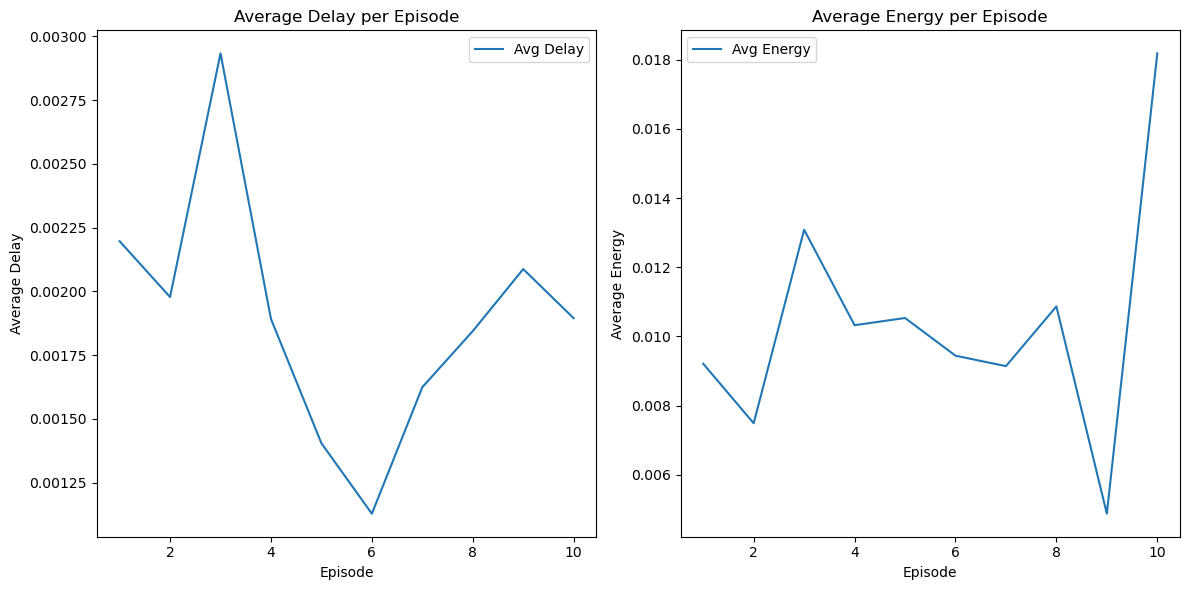

In [3]:
import numpy as np
import json
import matplotlib.pyplot as plt

class QLearningAgent:
    def __init__(self, env, num_users, alpha=0.1, gamma=0.95, epsilon=1, max_steps_per_episode=2):
        self.env = env
        self.num_users = num_users
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = {}
        self.max_steps_per_episode = max_steps_per_episode

    def get_state(self, state_info):
        state = self.env.get_state(state_info)
        return state

    def make_hashable(self, d):
        if isinstance(d, dict):
            return tuple(sorted((k, self.make_hashable(v)) for k, v in d.items()))
        if isinstance(d, list):
            return tuple(self.make_hashable(e) for e in d)
        if isinstance(d, np.ndarray):
            return tuple(d.tolist())
        return d
    
    def update_epsilon(self, decay_rate=0.995, min_epsilon=0.01):
        self.epsilon = max(min_epsilon, self.epsilon * decay_rate)

    def get_action(self, state):
        state_key = self.make_hashable(state)
        print(f"State Key: {state_key}")
        
        if state_key not in self.q_table:
            print("State key not in Q-table, initializing Q-values")
            self.q_table[state_key] = self.initialize_q_values()

        if np.random.uniform(0, 1) < self.epsilon:
            action = self.generate_random_action()
            print("Random Action:", action)
            action_key = tuple(action.items())
            if action_key not in self.q_table[state_key]:
                self.q_table[state_key][action_key] = 0
        else:
            action_key = max(self.q_table[state_key], key=self.q_table[state_key].get)
            action = dict(action_key)
            print("Q-table Action:", action)
        
        return action


    def initialize_q_values(self):
        q_values = {}
        random_action = self.generate_random_action()
        q_values[tuple(random_action.items())] = 0
        return q_values


    def generate_random_action(self):
        alpha = np.random.choice(np.linspace(0.1, 1, 3))
        b = np.random.choice(np.linspace(0.1, 0.3, 3))
        p = np.random.choice(np.linspace(self.env.P_max / 10, self.env.P_max, 3))
        f_ue = np.random.choice(np.linspace(self.env.F_max_ue / 3, self.env.F_max_ue, 3))
        f_es = np.random.choice(np.linspace(self.env.F_max_es / 100, self.env.F_max_es / 10, 3))

        action = {
            'alpha_m': alpha,
            'b_m': b,
            'p_m': p,
            'f_ue_m': f_ue,
            'f_es_m': f_es
        }

        return action

    def update_q_table(self, state, action, reward, next_state):
        state_key = self.make_hashable(state)
        action_key = tuple(action.items())
        next_state_key = self.make_hashable(next_state)

        if state_key not in self.q_table:
            self.q_table[state_key] = self.initialize_q_values()
        
        if action_key not in self.q_table[state_key]:
            self.q_table[state_key][action_key] = 0
        
        if next_state_key not in self.q_table:
            self.q_table[next_state_key] = self.initialize_q_values()

        current_q = self.q_table[state_key][action_key]
        max_next_q = max(self.q_table[next_state_key].values())

        self.q_table[state_key][action_key] = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)

        print(f"\nState: {state_key}")
        print(f"Action: {action_key}")
        print(f"Reward: {reward}")
        print(f"Next State: {next_state_key}")
        print("current_q :", current_q)
        print(f"Updated Q-value: {self.q_table[state_key][action_key]}")

    def train(self, num_episodes):
        avg_delays = []
        avg_energies = []

        for episode in range(num_episodes):
            state_info = self.env.reset()
            state = self.get_state(state_info)
            total_delay = 0
            total_energy = 0
            num_steps = 0
            states_choose_actions = [{
                'total_bandwidth': 0,
                'total_computation': 0,
                'current_time': 0,
                'cache_size': 0,
                'device_id': user_id,
                'task': None,
                'delay': 0,
                'energy': 0,
                'reward': 0,
                'cache_hit': 0,
                'Occupied bandwidth': 0,
                'Occupied computation': 0
            } for user_id in range(self.num_users)]

            for step in range(self.max_steps_per_episode):
                actions = []
                states_choose_actions = self.make_hashable(states_choose_actions)

                for user_id in range(self.num_users):
                    action = self.get_action(states_choose_actions[user_id])
                    actions.append(action)
                    print("actions : ",actions)

                rewards, next_state_info, done = self.env.step(actions)
                next_state = self.get_state(next_state_info)

                state_info_list = state_info['state_info']
                next_state_info_list = next_state_info['state_info']
                # Debug: print state_info and next_state_info
                print("next_state: ,", next_state)
                print(f"state_info: {state_info}")
                print(f"state: {state}")
                print(f"next_state_info: {next_state_info}")
                print("len(state_info_list): ",len(state_info_list))
                print("state_info_list: ",state_info_list)
                print("next_state_info_list: ",next_state_info_list)
                states_choose_actions = []

                for user_id in range(len(state_info_list)):
                    device_info = state_info_list[user_id]
                    next_device_info = next_state_info_list[user_id]
                    action = actions[user_id]
                    reward = rewards[user_id]
                    print(f"device_info: {device_info}")
                    print(f"next_device_info: {next_device_info}")
                    print(f"action: {actions[user_id]}")
                    print(f"reward: {rewards[user_id]}")
                    if isinstance(device_info, dict) and isinstance(next_device_info, dict):
                        state_without_last = {k: state[k] for k in list(state.keys())[:-1]}
                        next_state_without_last = {k: next_state[k] for k in list(next_state.keys())[:-1]}
                        combined_state = {**state_without_last, **device_info}
                        combined_next_state = {**next_state_without_last, **next_device_info}
                        states_choose_actions.append(combined_next_state)
                        print("combined_state111: ,", combined_state)

                        combined_state = self.make_hashable(combined_state)
                        combined_next_state = self.make_hashable(combined_next_state)
                        print("combined_state: ,", combined_state)
                        print("combined_next_state: ,", combined_next_state)

                        print("states_choose_actions: ,", states_choose_actions)
                        self.update_q_table(combined_state, action, reward, combined_next_state)
                        total_delay += next_device_info.get('delay', 0)
                        total_energy += next_device_info.get('energy', 0)
                    else:
                        raise TypeError("device_info and next_device_info must be dictionaries")

                state = next_state
                print("total_delay :",total_delay)
                print("total_energy :",total_energy)
                if done:
                    break

                num_steps += 1

            avg_delay = total_delay / num_steps if num_steps > 0 else 0
            avg_energy = total_energy / num_steps if num_steps > 0 else 0
            avg_delays.append(avg_delay)
            avg_energies.append(avg_energy)

            print(f'Episode {episode + 1}/{num_episodes} - Avg Delay: {avg_delay}, Avg Energy: {avg_energy}')
            print("-" * 100)
            
            # Update epsilon at the end of each episode
            self.update_epsilon()

        self.plot_results(avg_delays, avg_energies)

    def plot_results(self, avg_delays, avg_energies):
        episodes = np.arange(1, len(avg_delays) + 1)

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(episodes, avg_delays, label='Avg Delay')
        plt.xlabel('Episode')
        plt.ylabel('Average Delay')
        plt.title('Average Delay per Episode')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(episodes, avg_energies, label='Avg Energy')
        plt.xlabel('Episode')
        plt.ylabel('Average Energy')
        plt.title('Average Energy per Episode')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def save_q_table(self, filename):
        def convert_keys_to_str(d):
            if isinstance(d, dict):
                return {str(k): convert_keys_to_str(v) for k, v in d.items()}
            elif isinstance(d, np.ndarray):
                return d.tolist()
            else:
                return d

        with open(filename, 'w') as f:
            json.dump(convert_keys_to_str(self.q_table), f)

    def load_q_table(self, filename):
        def convert_keys_to_tuple(d):
            if isinstance(d, dict):
                return {eval(k): convert_keys_to_tuple(v) for k, v in d.items()}
            else:
                return d

        with open(filename, 'r') as f:
            self.q_table = convert_keys_to_tuple(json.load(f))


# Assuming you have your EdgeComputingEnvironment defined as per your code
env = EdgeComputingEnvironment()

# Define the number of users/devices
num_users = env.M

# Initialize the Q-learning agent
agent = QLearningAgent(env, num_users)

# Train the agent
num_episodes = 10  # Adjust the number of episodes as needed
agent.train(num_episodes)

# Show the Q-table
#agent.save_q_table('Q_table.json')
